## Cell segmentation
Download the pretrained StarDist model for H&E images:

https://github.com/stardist/stardist?tab=readme-ov-file#pretrained-models-for-2d

Create QuPath project, load the image and annotate the region of interest.
Run the [code](stardist_cell_segmentation.groovy) within QuPath.



In [10]:
import os
import pandas
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# make larger font size
plt.rcParams.update({'font.size': 14})

In [32]:
# case_id = 'GB-99'
case_id = 'GB-28'
cell_quant_dir = '/Users/jjiang10/Data/Gallbladder/CellSegmentation/Quantifications'
cell_cls_dir = '/Users/jjiang10/Data/Gallbladder/CellClassification/Tables'

cell_quant_fn = os.path.join(cell_quant_dir, case_id+'_measurements.tsv')
cell_cls_fn = os.path.join(cell_cls_dir, case_id+'_cell_classification.tsv')
cell_feature_umap_fn = os.path.join(cell_cls_dir, case_id+'_cell_feature_umap.tsv')

In [33]:
cell_xy_loc_idx_range = range(7, 9) # 7: x, 8: y
cell_morphology_idx_range = range(9, 21) 
cell_staining_idx_range = range(21, 62) # to column BJ

/Users/jjiang10/conda_envs/gallbladder/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jjiang10/conda_envs/gallbladder/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jjiang10/conda_envs/gallbladder/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jjiang10/conda_envs/gallbladder/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/jjiang10/conda_envs/gallbladder/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/jjiang10/conda_envs/gallbladder/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: 

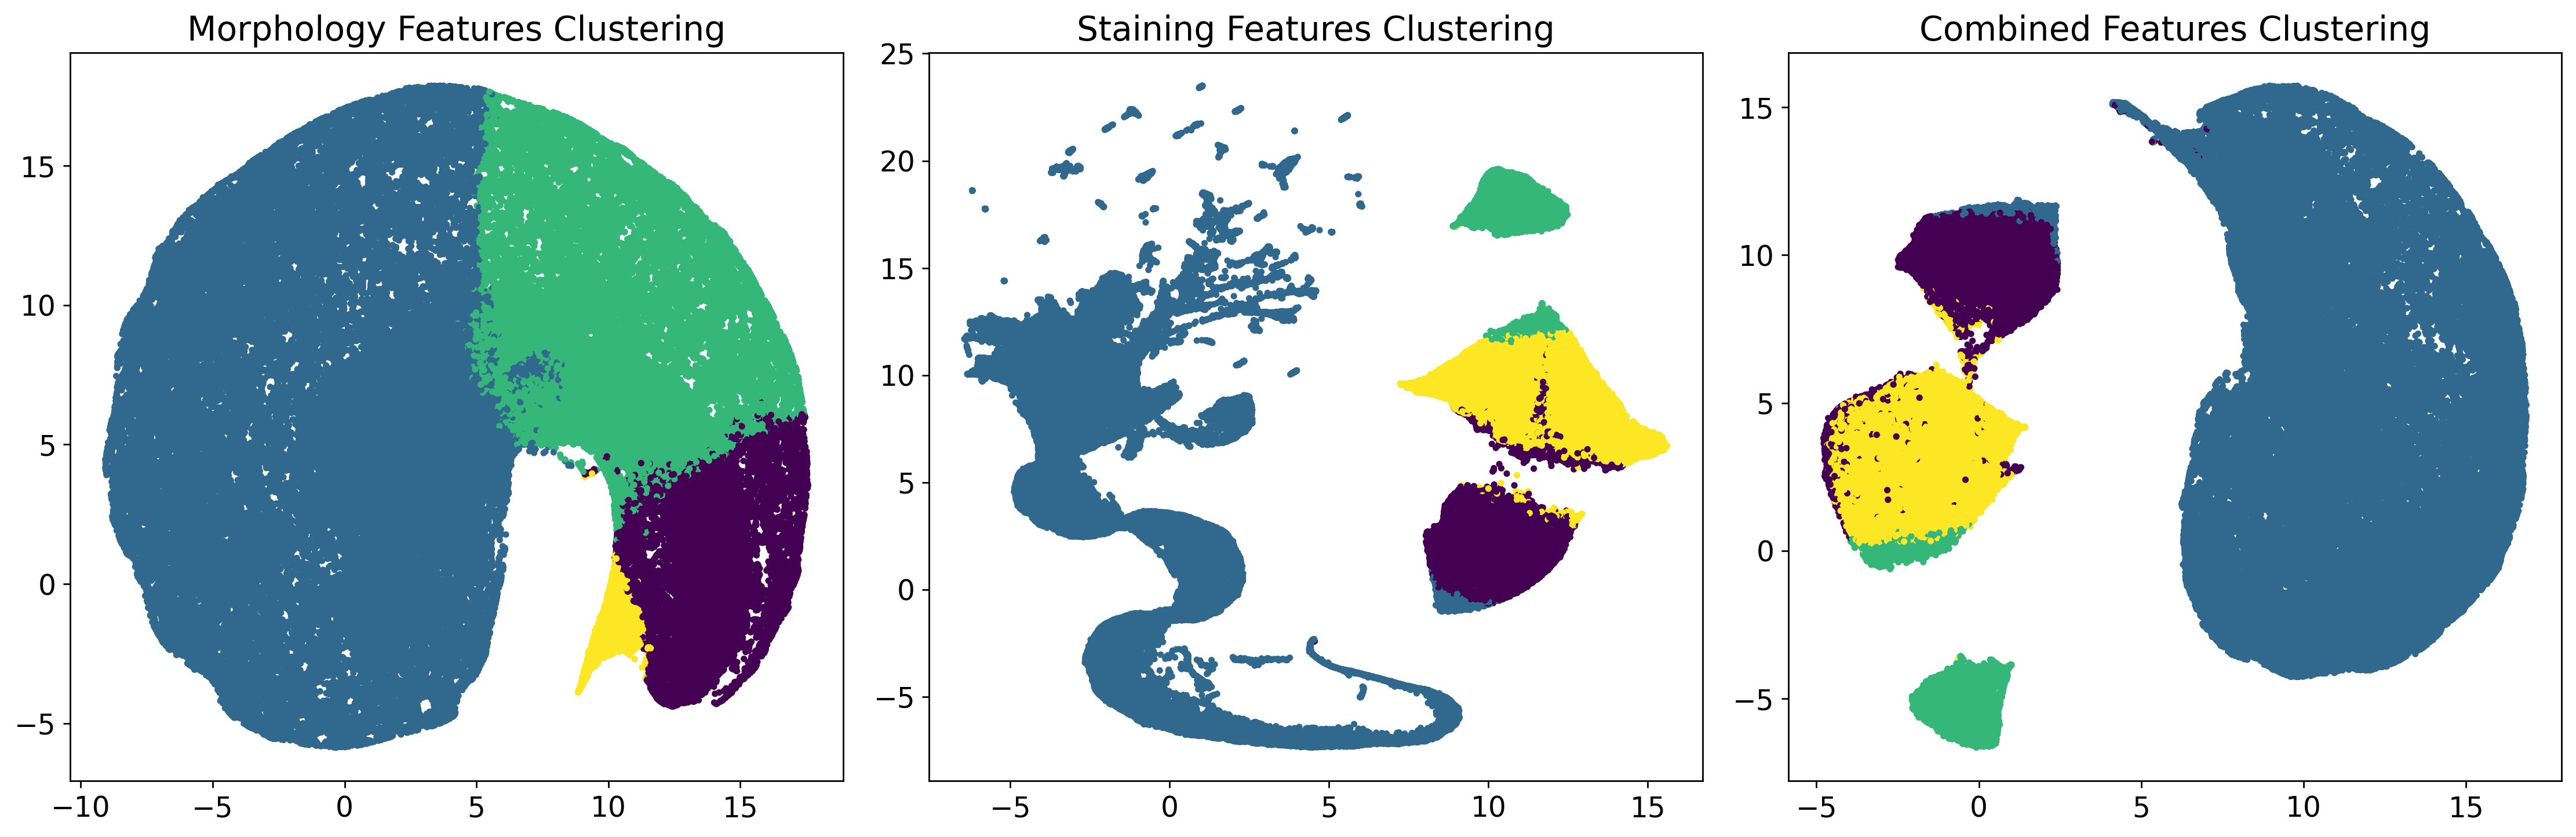

In [34]:

# Load the tsv file to get cell features
cell_quant_df = pandas.read_csv(cell_quant_fn, sep='\t')
# drop the rows with NaN values in the morphology and staining features
cell_quant_df = cell_quant_df.dropna(subset=cell_quant_df.columns[list(cell_morphology_idx_range) + list(cell_staining_idx_range)], how='any')

# Normalize cell features by column
cell_quant_df.iloc[:, list(cell_morphology_idx_range) + list(cell_staining_idx_range)] = \
    cell_quant_df.iloc[:, list(cell_morphology_idx_range) + list(cell_staining_idx_range)].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
    )

# Extract features
morphology_features = cell_quant_df.iloc[:, cell_morphology_idx_range]
staining_features = cell_quant_df.iloc[:, cell_staining_idx_range]
combined_features = pandas.concat([morphology_features, staining_features], axis=1)

# Perform KMeans clustering
kmeans_morphology = KMeans(n_clusters=4, random_state=42).fit(morphology_features)
kmeans_staining = KMeans(n_clusters=4, random_state=42).fit(staining_features)
kmeans_combined = KMeans(n_clusters=4, random_state=42).fit(combined_features)

# Add cluster labels to the dataframe
cell_quant_df['Morphology_Cluster'] = kmeans_morphology.labels_
cell_quant_df['Staining_Cluster'] = kmeans_staining.labels_
cell_quant_df['Combined_Cluster'] = kmeans_combined.labels_

# Perform UMAP dimensionality reduction
umap_reducer = umap.UMAP(random_state=42)
morphology_umap = umap_reducer.fit_transform(morphology_features)
staining_umap = umap_reducer.fit_transform(staining_features)
combined_umap = umap_reducer.fit_transform(combined_features)

# Plot the clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=250)

axes[0].scatter(morphology_umap[:, 0], morphology_umap[:, 1], c=kmeans_morphology.labels_, cmap='viridis', s=5)
axes[0].set_title('Morphology Features Clustering')

axes[1].scatter(staining_umap[:, 0], staining_umap[:, 1], c=kmeans_staining.labels_, cmap='viridis', s=5)
axes[1].set_title('Staining Features Clustering')

axes[2].scatter(combined_umap[:, 0], combined_umap[:, 1], c=kmeans_combined.labels_, cmap='viridis', s=5)
axes[2].set_title('Combined Features Clustering')

plt.tight_layout()
plt.show()

In [ ]:
# Create a new dataframe with the required columns
cell_feature_umap_df = cell_quant_df[['Centroid X µm', 'Centroid Y µm']].copy()
cell_feature_umap_df['umap_x'] = combined_umap[:, 0]
cell_feature_umap_df['umap_y'] = combined_umap[:, 1]
cell_feature_umap_df['Combined_Cluster'] = kmeans_combined.labels_

# # Remove rows where 'umap_x' is larger than 4
# cell_feature_umap_df = cell_feature_umap_df[cell_feature_umap_df['umap_x'] <= 4]
# Save the dataframe to the specified file
cell_feature_umap_df.to_csv(cell_feature_umap_fn, sep='\t', index=False)

In [38]:

# Save the updated dataframe to the specified file
cell_quant_df.to_csv(cell_cls_fn, sep='\t', index=False)
len(cell_quant_df['Centroid Y µm'])

147303

In [37]:


# Calculate permutation importance for morphology features
morphology_importance = permutation_importance(kmeans_morphology, morphology_features, kmeans_morphology.labels_, random_state=42)

# Calculate permutation importance for staining features
staining_importance = permutation_importance(kmeans_staining, staining_features, kmeans_staining.labels_, random_state=42)

# Calculate permutation importance for combined features
combined_importance = permutation_importance(kmeans_combined, combined_features, kmeans_combined.labels_, random_state=42)

# Display the top features for each scenario
morphology_top_features = morphology_importance.importances_mean.argsort()[::-1]
staining_top_features = staining_importance.importances_mean.argsort()[::-1]
combined_top_features = combined_importance.importances_mean.argsort()[::-1]

print("Top Morphology Features:", morphology_features.columns[morphology_top_features[:5]])
print("Top Staining Features:", staining_features.columns[staining_top_features[:5]])
print("Top Combined Features:", combined_features.columns[combined_top_features[:5]])

Top Morphology Features: Index(['Nucleus: Circularity', 'Cell: Circularity', 'Nucleus: Solidity',
       'Cell: Solidity', 'Cell: Max diameter µm'],
      dtype='object')
Top Staining Features: Index(['Hematoxylin: Cell: Max', 'Hematoxylin: Nucleus: Max',
       'Eosin: Nucleus: Max', 'Eosin: Cell: Max',
       'Hematoxylin: Nucleus: Std.Dev.'],
      dtype='object')
Top Combined Features: Index(['Hematoxylin: Cell: Max', 'Hematoxylin: Nucleus: Max',
       'Eosin: Nucleus: Max', 'Eosin: Cell: Max',
       'Hematoxylin: Nucleus: Std.Dev.'],
      dtype='object')


### References
 SHAP https://valooresanalyticsdept.medium.com/shap-for-credit-risk-interpreting-machine-learning-black-box-459a511e9e1e